# SC4003 Assignment 1

## Function Definitions

### Initialise Values and Constants

In [237]:
from enum import Enum
from decimal import Decimal
import matplotlib.pyplot as plt
import numpy as np

P_STRAIGHT = 0.8
P_LEFT = 0.1
P_RIGHT = 0.1

DISCOUNT = 0.99
# Defines the threshold for convergence
THRESHOLD_THETA = 0.001
MAX_ITERATIONS = 800
SAMPLING_INTERVAL = 100

ROWS = 6
COLS = 6

START_COORDS = (2, 2)

# Enum to define actions that agent can take
class Actions(Enum):
    UP = 0
    RIGHT = 90
    DOWN = 180
    LEFT = 270
    NONE = -1
    def prev(self):
        cls = self.__class__
        members = list(cls)
        index = members.index(self) - 1
        if index < 0:
            index = len(members)-2
        return members[index]

    def next(self):
        cls = self.__class__
        members = list(cls)
        index = members.index(self) + 1
        if index >= len(members) - 1:
            index = 0
        return members[index]

# Define cell types in grid world and corresponding rewards
class CellType(Enum):
    WALL = 0, 0
    WHITE = 1, -0.05
    GREEN = 2, 1
    BROWN = 3, -1
    BLUE = 4, 3
    RED = 5, -3

    def __new__(cls, value, reward):
        member = object.__new__(cls)
        member._value_ = value
        member.reward = Decimal(reward)
        return member

    def _int__(self):
        return self.value

### Grid class to simulate Tileworld

In [238]:
# Define Grid class to simulate Tileworld
class Grid():
    # Define grid
    # Default initialisation
    def __init__(self):
        self.grid = [[CellType.WHITE for j in range(COLS)] for i in range(ROWS)]
        self.utilities = [[0 for j in range(COLS)] for i in range(ROWS)]
        self.policies = [[Actions.NONE for j in range(COLS)] for i in range(ROWS)];

    def get_utilities(self):
        return self.utilities

    def initialise_values(self, value: int):
        self.utilities = [[value for j in range(COLS)] for i in range(ROWS)]

    def initialise_policies(self, action: Actions):
        self.policies = [[action for j in range(COLS)] for i in range(ROWS)];

    def get_policies(self):
        return self.policies

    def update_policies(self, policies):
        self.policies = [r[:] for r in policies]

    def update_utilities(self, utilities):
        self.utilities = [r[:] for r in utilities]
    
    def initialise(self, green_cells, brown_cells, wall_cells, blue_cells = [], red_cells = []):
        for r, c in green_cells:
            self.grid[r][c] = CellType.GREEN
        for r, c in brown_cells:
            self.grid[r][c] = CellType.BROWN
        for r, c in wall_cells:
            self.grid[r][c] = CellType.WALL
        for r, c in red_cells:
            self.grid[r][c] = CellType.RED
        for r, c in blue_cells:
            self.grid[r][c] = CellType.BLUE

    def get_reward(self, r, c):
        return self.grid[r][c].reward
    
    def get_state(self, r, c) -> CellType:
        return self.grid[r][c]
    
    def get_utility(self, r, c) -> int:
        return self.utilities[r][c]

    # Function to get utility of next state and immediate reward
    def get_next_state(self, r: int, c: int, action: Actions):
        new_r, new_c = r, c
        if action == Actions.UP:
            if r != ROWS-1:
                new_r += 1
        elif action == Actions.RIGHT:
            if c != COLS-1:
                new_c += 1
        elif action == Actions.LEFT:
            if c != 0:
                new_c -= 1
        elif action == Actions.DOWN:
            if r != 0:
                new_r -= 1
        
        # if hit wall or stay in place
        if self.grid[new_r][new_c] == CellType.WALL:
            return self.utilities[r][c]
        return self.utilities[new_r][new_c]
        
    def update_utility(self, r, c, utility):
        self.utilities[r][c] = utility


### Helper Functions 

In [239]:
# Function to calculate expected utility
def get_expected_utility(reward, utility_list, prob_list):
    result = Decimal(reward)

    for i in range(len(prob_list)):
        result += Decimal(DISCOUNT) * Decimal(utility_list[i]) * Decimal(prob_list[i])

    return result

# Functiion to print 2D array (policy or utility map)
def print_2d_arr(arr):
    for r in range(len(arr)-1, -1, -1):
        line = ""
        for c in range(len(arr[0])):
            if (isinstance(arr[r][c], Decimal)):
                # line += " " + str(round(arr[r][c], 1))
                line += " " + str(round(arr[r][c], 1))
            elif (isinstance(arr[r][c], Actions)):
                line += " " + str(arr[r][c].name)
            else:
                line += " " + str(arr[r][c])
        print(line + "\n")

# Function to get average utility in 2D array
def get_avg_utility(arr):
    total = 0
    for r in range(len(arr)-1, -1, -1):
        for c in range(len(arr[0])):
            total += arr[r][c]
    
    return Decimal(total / (len(arr)) * (len(arr[0])))

### Value Iteration Function

In [240]:
def value_iteration(grid: Grid, iterations: int = MAX_ITERATIONS, complete_iter: bool = False):
    # Initialise all values to 0
    grid.initialise_values(0)
    utility_map = [r[:] for r in grid.get_utilities()]
    policy_map = [r[:] for r in grid.get_policies()]
    iter = 0
    # Max diff
    max_diff = float("inf")
    # Continue iteration until maximum difference between iterations less than threshold difference
    
    for _ in range(iterations):
        max_diff = -float("inf")
        for r in range(ROWS):
            for c in range(COLS):
                if grid.get_state(r, c) == CellType.WALL:
                    continue

                # Get optimal value and policy
                v_max = -float("inf")
                a_max = Actions.UP
                for a in Actions:
                    if a == Actions.NONE:
                        continue
                    
                    reward = grid.get_reward(r, c)
                    # Get expected future utility and immediate reward
                    u_1 = grid.get_next_state(r, c, a) # Straight
                    u_2 = grid.get_next_state(r, c, a.prev()) # Left
                    u_3 = grid.get_next_state(r, c, a.next()) # Right
                    
                    # Calculate expected utility
                    v = get_expected_utility(reward, [u_1, u_2, u_3], [P_STRAIGHT, P_LEFT, P_RIGHT])
                    if(v > v_max):
                        a_max = a
                        v_max = v

                # Get current value
                v_curr = grid.get_utility(r, c)

                # Get max diff
                max_diff = max(max_diff, (abs(v_curr - v_max)))
                utility_map[r][c] = v_max
                policy_map[r][c] = a_max.name
        iter += 1
        # Update utilities stored in grid at end of iteration
        grid.update_utilities(utility_map)

        # Break when convergence if iterations not completed
        if not complete_iter and max_diff < THRESHOLD_THETA:
            break
  
    return policy_map, utility_map 

### Policy Iteration Function

In [241]:
# Policy Iteration
def policy_iteration(grid: Grid, iterations: int = MAX_ITERATIONS, complete_iter: bool = False):
    # Initialise policy
    grid.initialise_policies(Actions.UP)
    grid.initialise_values(0)

    policy_map = [r[:] for r in grid.get_policies()]
    utility_map = [r[:] for r in grid.get_utilities()]
    iter = 0

    for _ in range(iterations):
        evaluation_converge = False
        # Policy Evaluation
        max_diff = float("inf")
        while max_diff > THRESHOLD_THETA:
            max_diff = -float("inf")
            for r in range(ROWS):
                for c in range(COLS):
                    if grid.get_state(r, c) == CellType.WALL:
                        policy_map[r][c] = Actions.NONE
                        continue

                    # Get current policy
                    a = policy_map[r][c]
                    # Get current utility
                    v_prev = grid.get_utility(r, c)

                    reward = grid.get_reward(r, c)
                    u_1 = grid.get_next_state(r, c, a) # Straight
                    u_2 = grid.get_next_state(r, c, a.prev()) # Left
                    u_3 = grid.get_next_state(r, c, a.next()) # Right
                        
                    # Calculate expected utility of current policy
                    v = get_expected_utility(reward, [u_1, u_2, u_3], [P_STRAIGHT, P_LEFT, P_RIGHT])

                    # Get max diff
                    max_diff = max(max_diff, (abs(v_prev - v)))
                    utility_map[r][c] = v
            grid.update_utilities(utility_map)
    
        # Policy Improvement
        policy_stable = True
        for r in range(ROWS):
            for c in range(COLS):
                # Get current policy
                a_prev = policy_map[r][c]

                # Skip if state is a wall
                if grid.get_state(r, c) == CellType.WALL:
                    policy_map[r][c] == Actions.NONE
                    continue

                v_max = -float("inf")
                a_max = a_prev

                # Find action with max utility
                for a in Actions:
                    if a == Actions.NONE:
                        continue
                    
                    reward = grid.get_reward(r, c)
                    u_1 = grid.get_next_state(r, c, a) # Straight
                    u_2 = grid.get_next_state(r, c, a.prev()) # Left
                    u_3 = grid.get_next_state(r, c, a.next()) # Right
                        
                    # Calculate expected utility
                    v = get_expected_utility(reward, [u_1, u_2, u_3], [P_STRAIGHT, P_LEFT, P_RIGHT])

                    # Update best action
                    if v > v_max:
                        v_max = v
                        a_max = a

                if a_prev != a_max:
                    policy_stable = False
                policy_map[r][c] = a_max
        grid.update_policies(policy_map)

        # Break when policies converge if no need to complete iterations
        if not complete_iter and policy_stable:
            break
        iter += 1

    return policy_map, utility_map

#### Functions to get data for graph plots

In [242]:
# Helper functions to get data for plots
def get_value_iteration_data(grid):
    utility_estimates = [[[] for j in range(COLS)] for i in range(ROWS)]
    iteration_values = []
    average_utility_estimates = []

    MAX_ITERATIONS = 800
    SAMPLING_INTERVAL = 100

    # Add to graph
    for i in range(0, MAX_ITERATIONS, SAMPLING_INTERVAL):
        _, utility_map = value_iteration(grid, i, True)
        total = 0
        for r in range(ROWS):
            for c in range(COLS):
                utility_estimates[r][c].append(utility_map[r][c])
                total += utility_map[r][c]
        average_utility_estimates.append(Decimal(total / (ROWS * COLS)))
        iteration_values.append(i)

    iteration_values_np = np.array(iteration_values)
    average_utility_estimates_np = np.array(average_utility_estimates)

    return utility_estimates, iteration_values_np, average_utility_estimates_np

def get_policy_iteration_data(grid):
    utility_estimates = [[[] for j in range(COLS)] for i in range(ROWS)]
    iteration_values = []
    average_utility_estimates = []

    MAX_ITERATIONS = 10
    SAMPLING_INTERVAL = 1

    # Add to graph
    for i in range(0, MAX_ITERATIONS, SAMPLING_INTERVAL):
        _, utility_map = policy_iteration(grid, i, True)
        total = 0
        for r in range(ROWS):
            for c in range(COLS):
                utility_estimates[r][c].append(utility_map[r][c])
                total += utility_map[r][c]
        average_utility_estimates.append(Decimal(total / (ROWS * COLS)))
        iteration_values.append(i)

    iteration_values_np = np.array(iteration_values)
    average_utility_estimates_np = np.array(average_utility_estimates)

    return utility_estimates, iteration_values_np, average_utility_estimates_np

# Part 1

### Definition of Gridworld 

In [243]:
# Define grid cells
green_cells = [(5, 0), (5, 2), (5, 5), (4, 3), (3, 4), (2, 5)]
brown_cells = [(4, 1), (4, 5), (3, 2), (2, 3), (1, 4)]
wall_cells = [(5, 1), (4, 4), (1, 1), (1, 2), (1, 3)]
grid = Grid()

# Initialise grid with values
grid.initialise(green_cells, brown_cells, wall_cells)

### Value Iteration of Given Gridworld

In [244]:
# Perform value iteration to retrieve optimal policies and utilities for all cells
policy_map, utility_map = value_iteration(grid)

print("======== OPTIMAL POLICIES ======== \n")
print_2d_arr(policy_map)
print("======== OPTIMAL UTILITIES ======== \n")
print_2d_arr(utility_map)


======== OPTIMAL POLICIES ======== 

 UP NONE LEFT LEFT LEFT UP

 UP LEFT LEFT LEFT NONE UP

 UP LEFT LEFT UP LEFT LEFT

 UP LEFT LEFT UP UP UP

 UP NONE NONE NONE UP UP

 UP LEFT LEFT LEFT UP UP

======== OPTIMAL UTILITIES ======== 

 99.9 0 94.9 93.7 92.5 93.2

 98.3 95.8 94.4 94.3 0 90.8

 96.8 95.5 93.2 93.0 93.0 91.6

 95.4 94.3 93.1 91.0 91.7 91.7

 94.2 0 0 0 89.4 90.4

 92.8 91.6 90.3 89.2 88.4 89.1



### Plotting Utility Estimates 

#### Sampling Utility Estimates

In [245]:
utility_estimates, iteration_values_np, average_utility_estimates_np = get_value_iteration_data(grid)

#### Plotting Graphs

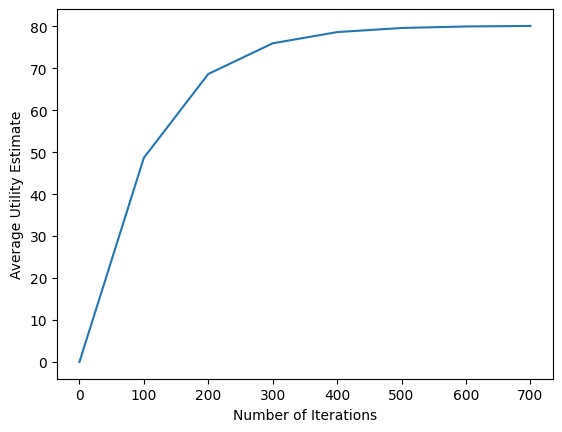

In [246]:
plt.plot(iteration_values_np, average_utility_estimates_np)
plt.xlabel("Number of Iterations")  # add X-axis label
plt.ylabel("Average Utility Estimate")  # add Y-axis label
plt.show()

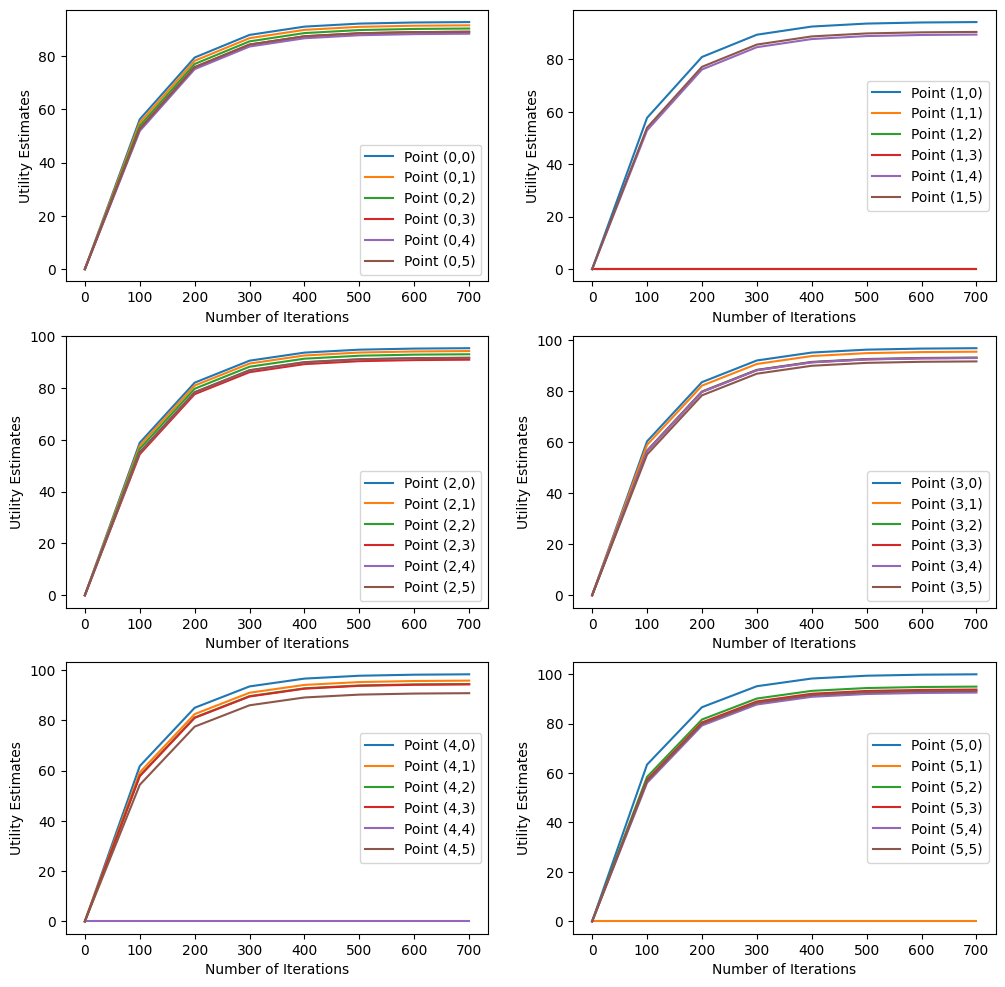

In [247]:
# For each cell in the grid, plot its utility estimate at each interval
figure, axis = plt.subplots(3, 2)
figure.set_figheight(12)
figure.set_figwidth(12)


for r in range(ROWS):
    for c in range(COLS):
        axis[r // 2, r % 2].plot(iteration_values_np, np.array(utility_estimates[r][c]), label="Point (" + str(r) + "," + str(c) + ")")
        axis[r // 2, r % 2].legend()
        axis[r // 2, r % 2].set_xlabel("Number of Iterations")
        axis[r // 2, r % 2].set_ylabel("Utility Estimates")

plt.show()


### Policy Iteration of Given Gridworld

In [248]:
policy_map, utility_map = policy_iteration(grid)

print("======== OPTIMAL POLICIES ======== \n")
print_2d_arr(policy_map)
print("======== OPTIMAL UTILITIES ======== \n")
print_2d_arr(utility_map)

======== OPTIMAL POLICIES ======== 

 UP NONE LEFT LEFT LEFT UP

 UP LEFT LEFT LEFT NONE UP

 UP LEFT LEFT UP LEFT LEFT

 UP LEFT LEFT UP UP UP

 UP NONE NONE NONE UP UP

 UP LEFT LEFT LEFT UP UP

======== OPTIMAL UTILITIES ======== 

 100.0 0 95.0 93.8 92.6 93.3

 98.4 95.9 94.5 94.4 0 90.9

 96.9 95.5 93.3 93.1 93.1 91.7

 95.5 94.4 93.2 91.1 91.8 91.8

 94.3 0 0 0 89.5 90.5

 92.9 91.7 90.4 89.3 88.5 89.2



#### Plotting Utility Estimates

##### Sampling Utility Estimates

In [249]:
utility_estimates, iteration_values_np, average_utility_estimates_np = get_policy_iteration_data(grid)

##### Plotting Graphs

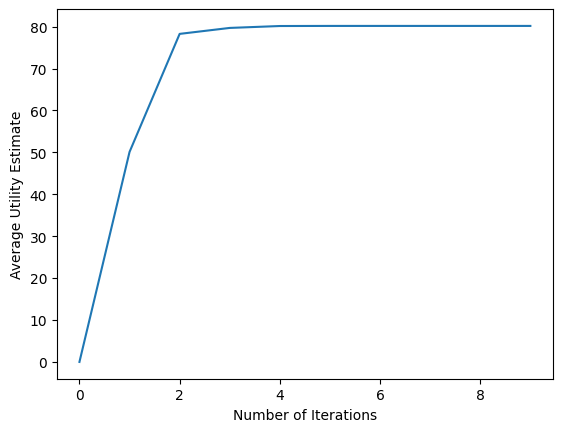

In [250]:
plt.plot(iteration_values_np, average_utility_estimates_np)
plt.xlabel("Number of Iterations")  # add X-axis label
plt.ylabel("Average Utility Estimate")  # add Y-axis label
plt.show()

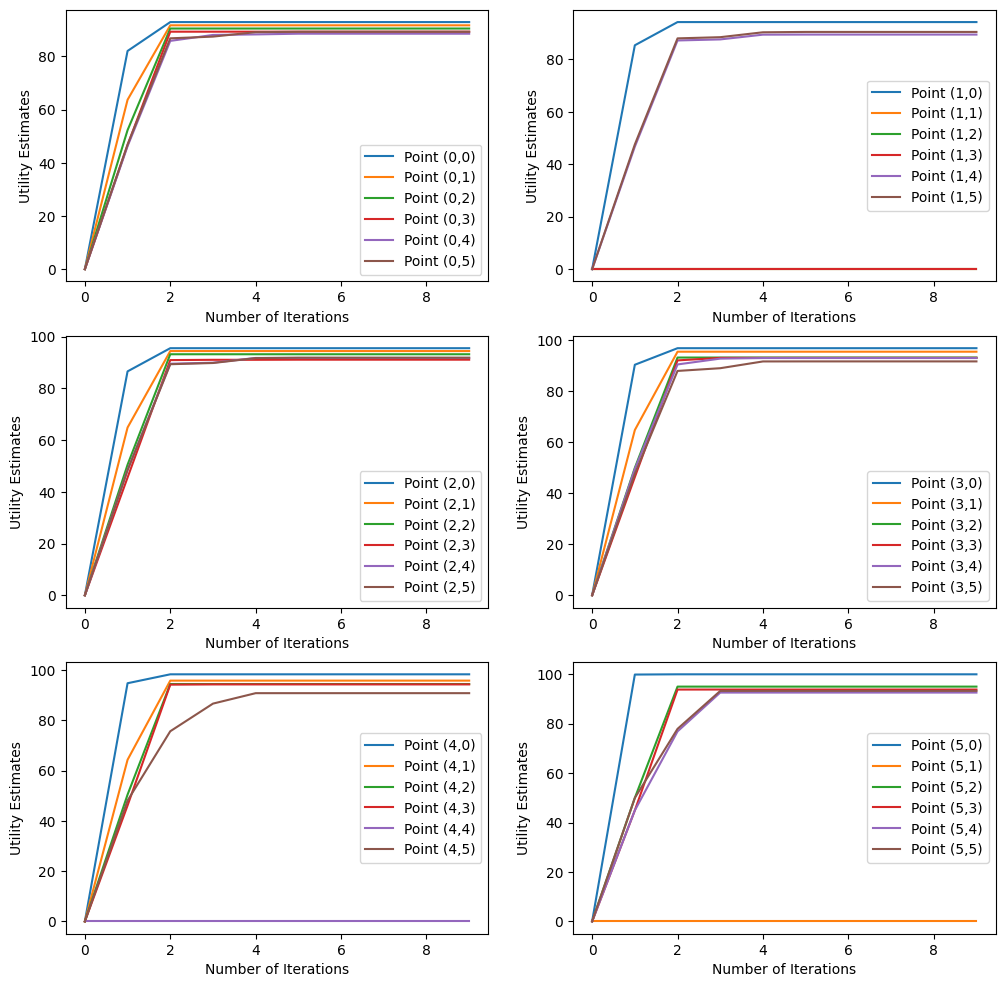

In [251]:
figure, axis = plt.subplots(3, 2)
figure.set_figheight(12)
figure.set_figwidth(12)

for r in range(ROWS):
    for c in range(COLS):
        axis[r // 2, r % 2].plot(iteration_values_np, np.array(utility_estimates[r][c]), label="Point (" + str(r) + "," + str(c) + ")")
        axis[r // 2, r % 2].legend()
        axis[r // 2, r % 2].set_xlabel("Number of Iterations")
        axis[r // 2, r % 2].set_ylabel("Utility Estimates")

plt.show()

# Part 2

### Definition of New Gridworld

The new, more complex Gridworld has 2 new square types, Blue and Red.

Blue squares give a reward of +3, while red squares give a reward of -3.  Furthermore, it has 3 more rows and columns.

In [252]:
ROWS = 9
COLS = 9

green_cells = [(6, 0), (4, 1), (0, 2), (4, 3), (1, 5), (2, 5), (5, 5), (7, 3), (8, 2), (3, 8)]
blue_cells = [(4, 0), (2, 1), (5, 2), (1, 3), (4, 4), (6, 5), (1, 6), (4, 7), (0, 7), (8, 8)]
brown_cells = [(1, 0), (1, 1), (3, 1), (5, 1), (0, 3), (3, 4), (6, 4), (6, 5), (7, 4), (7, 5)]
red_cells = [(3, 0), (0, 1), (6, 2), (3, 3), (1, 4), (0, 5), (4, 6), (6, 6), (2, 7), (8, 1), (2, 8)]
wall_cells = [(2, 2), (5, 3), (6, 3), (0, 4), (3, 5), (4, 5), (7, 1), (7, 6), (3, 7), (8, 7)]


grid = Grid()
grid.initialise(green_cells, brown_cells, wall_cells, blue_cells, red_cells)

### Value Iteration of New Gridworld

In [253]:
# Perform value iteration to retrieve optimal policies and utilities for all cells
policy_map, utility_map = value_iteration(grid)

print("======== OPTIMAL POLICIES ======== \n")
print_2d_arr(policy_map)
print("======== OPTIMAL UTILITIES ======== \n")
print_2d_arr(utility_map)

======== OPTIMAL POLICIES ======== 

 DOWN RIGHT RIGHT DOWN RIGHT DOWN LEFT NONE UP

 DOWN NONE RIGHT RIGHT DOWN DOWN NONE RIGHT UP

 DOWN DOWN DOWN NONE RIGHT RIGHT RIGHT RIGHT UP

 DOWN RIGHT DOWN NONE RIGHT RIGHT RIGHT RIGHT UP

 RIGHT RIGHT RIGHT RIGHT UP NONE RIGHT RIGHT UP

 UP UP UP UP UP NONE UP NONE UP

 RIGHT UP NONE RIGHT UP RIGHT UP RIGHT UP

 UP UP RIGHT UP RIGHT RIGHT UP RIGHT UP

 UP RIGHT UP UP NONE UP UP DOWN UP

======== OPTIMAL UTILITIES ======== 

 252.6 255.3 262.3 264.2 267.1 270.1 266.7 0 299.9

 255.5 0 263.5 267.5 270.0 274.4 0 291.4 295.6

 258.8 259.3 260.1 0 274.4 279.7 280.3 287.7 291.4

 260.7 262.6 267.3 0 274.5 278.0 280.1 284.1 287.3

 263.8 264.6 267.5 271.4 274.4 0 276.6 283.9 283.7

 257.2 260.1 263.8 264.7 269.2 0 273.1 0 281.4

 256.5 260.2 0 262.4 265.5 266.8 269.0 266.1 273.2

 252.4 255.6 258.5 262.1 259.6 265.9 268.7 266.1 269.4

 249.3 249.7 255.9 257.4 0 259.5 264.9 267.1 266.1



#### Plotting Utility Estimates

##### Sampling Utility Estimates

In [254]:
utility_estimates, iteration_values_np, average_utility_estimates_np = get_value_iteration_data(grid)

##### Plotting Graphs

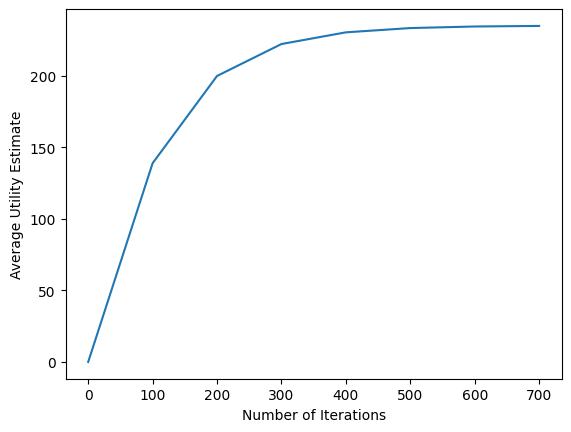

In [255]:
plt.plot(iteration_values_np, average_utility_estimates_np)
plt.xlabel("Number of Iterations")  # add X-axis label
plt.ylabel("Average Utility Estimate")  # add Y-axis label
plt.show()

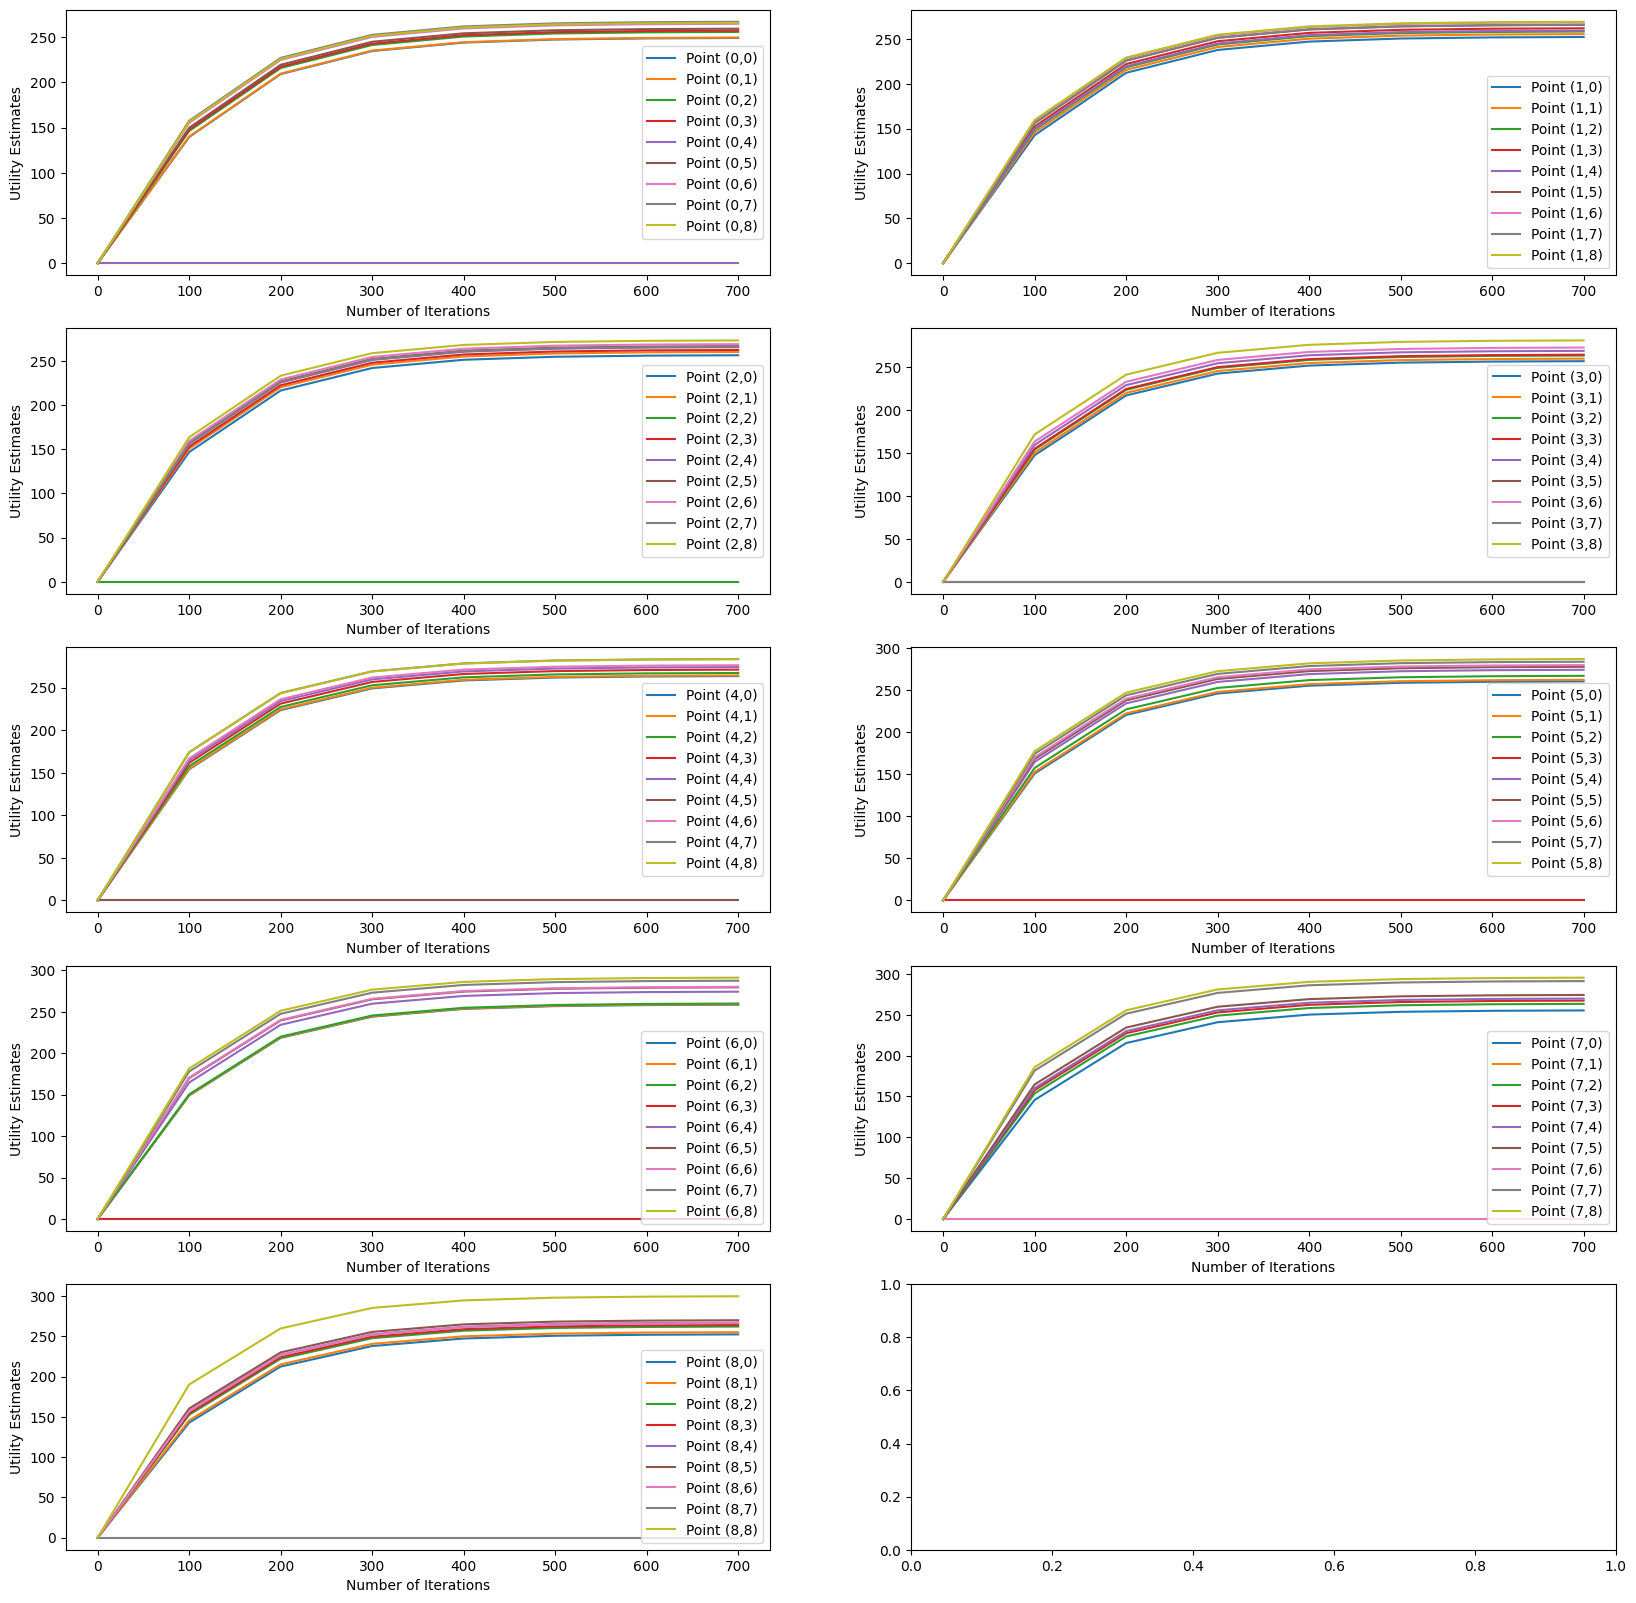

In [256]:
figure, axis = plt.subplots(5, 2)
figure.set_figheight(20)
figure.set_figwidth(20)

for r in range(ROWS):
    for c in range(COLS):
        axis[r // 2, r % 2].plot(iteration_values_np, np.array(utility_estimates[r][c]), label="Point (" + str(r) + "," + str(c) + ")")
        axis[r // 2, r % 2].legend()
        axis[r // 2, r % 2].set_xlabel("Number of Iterations")
        axis[r // 2, r % 2].set_ylabel("Utility Estimates")

plt.show()

### Policy Iteration of New Gridworld

In [257]:
policy_map, utility_map = policy_iteration(grid)

print("======== OPTIMAL POLICIES ======== \n")
print_2d_arr(policy_map)
print("======== OPTIMAL UTILITIES ======== \n")
print_2d_arr(utility_map)

======== OPTIMAL POLICIES ======== 

 DOWN RIGHT RIGHT DOWN RIGHT DOWN LEFT NONE UP

 DOWN NONE RIGHT RIGHT DOWN DOWN NONE RIGHT UP

 DOWN DOWN DOWN NONE RIGHT RIGHT RIGHT RIGHT UP

 DOWN RIGHT DOWN NONE RIGHT RIGHT RIGHT RIGHT UP

 RIGHT RIGHT RIGHT RIGHT UP NONE RIGHT RIGHT UP

 UP UP UP UP UP NONE UP NONE UP

 RIGHT UP NONE RIGHT UP RIGHT UP RIGHT UP

 UP UP RIGHT UP RIGHT RIGHT UP RIGHT UP

 UP RIGHT UP UP NONE UP UP DOWN UP

======== OPTIMAL UTILITIES ======== 

 252.7 255.4 262.4 264.3 267.2 270.2 266.8 0 300.0

 255.6 0 263.6 267.6 270.1 274.5 0 291.5 295.7

 258.9 259.4 260.2 0 274.5 279.8 280.4 287.8 291.5

 260.8 262.7 267.4 0 274.6 278.1 280.2 284.2 287.4

 263.9 264.7 267.6 271.5 274.5 0 276.7 284.0 283.8

 257.3 260.2 263.9 264.8 269.3 0 273.2 0 281.5

 256.6 260.3 0 262.5 265.6 266.9 269.1 266.2 273.3

 252.5 255.7 258.6 262.2 259.7 266.0 268.8 266.2 269.5

 249.4 249.8 256.0 257.5 0 259.6 265.0 267.2 266.2



#### Plotting Utility Estimates

##### Sampling Utility Estimates

In [258]:
utility_estimates, iteration_values_np, average_utility_estimates_np = get_policy_iteration_data(grid)

##### Plotting Graphs

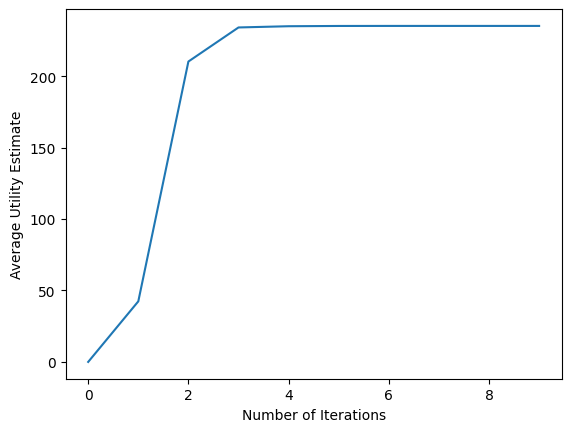

In [259]:
plt.plot(iteration_values_np, average_utility_estimates_np)
plt.xlabel("Number of Iterations")  # add X-axis label
plt.ylabel("Average Utility Estimate")  # add Y-axis label
plt.show()

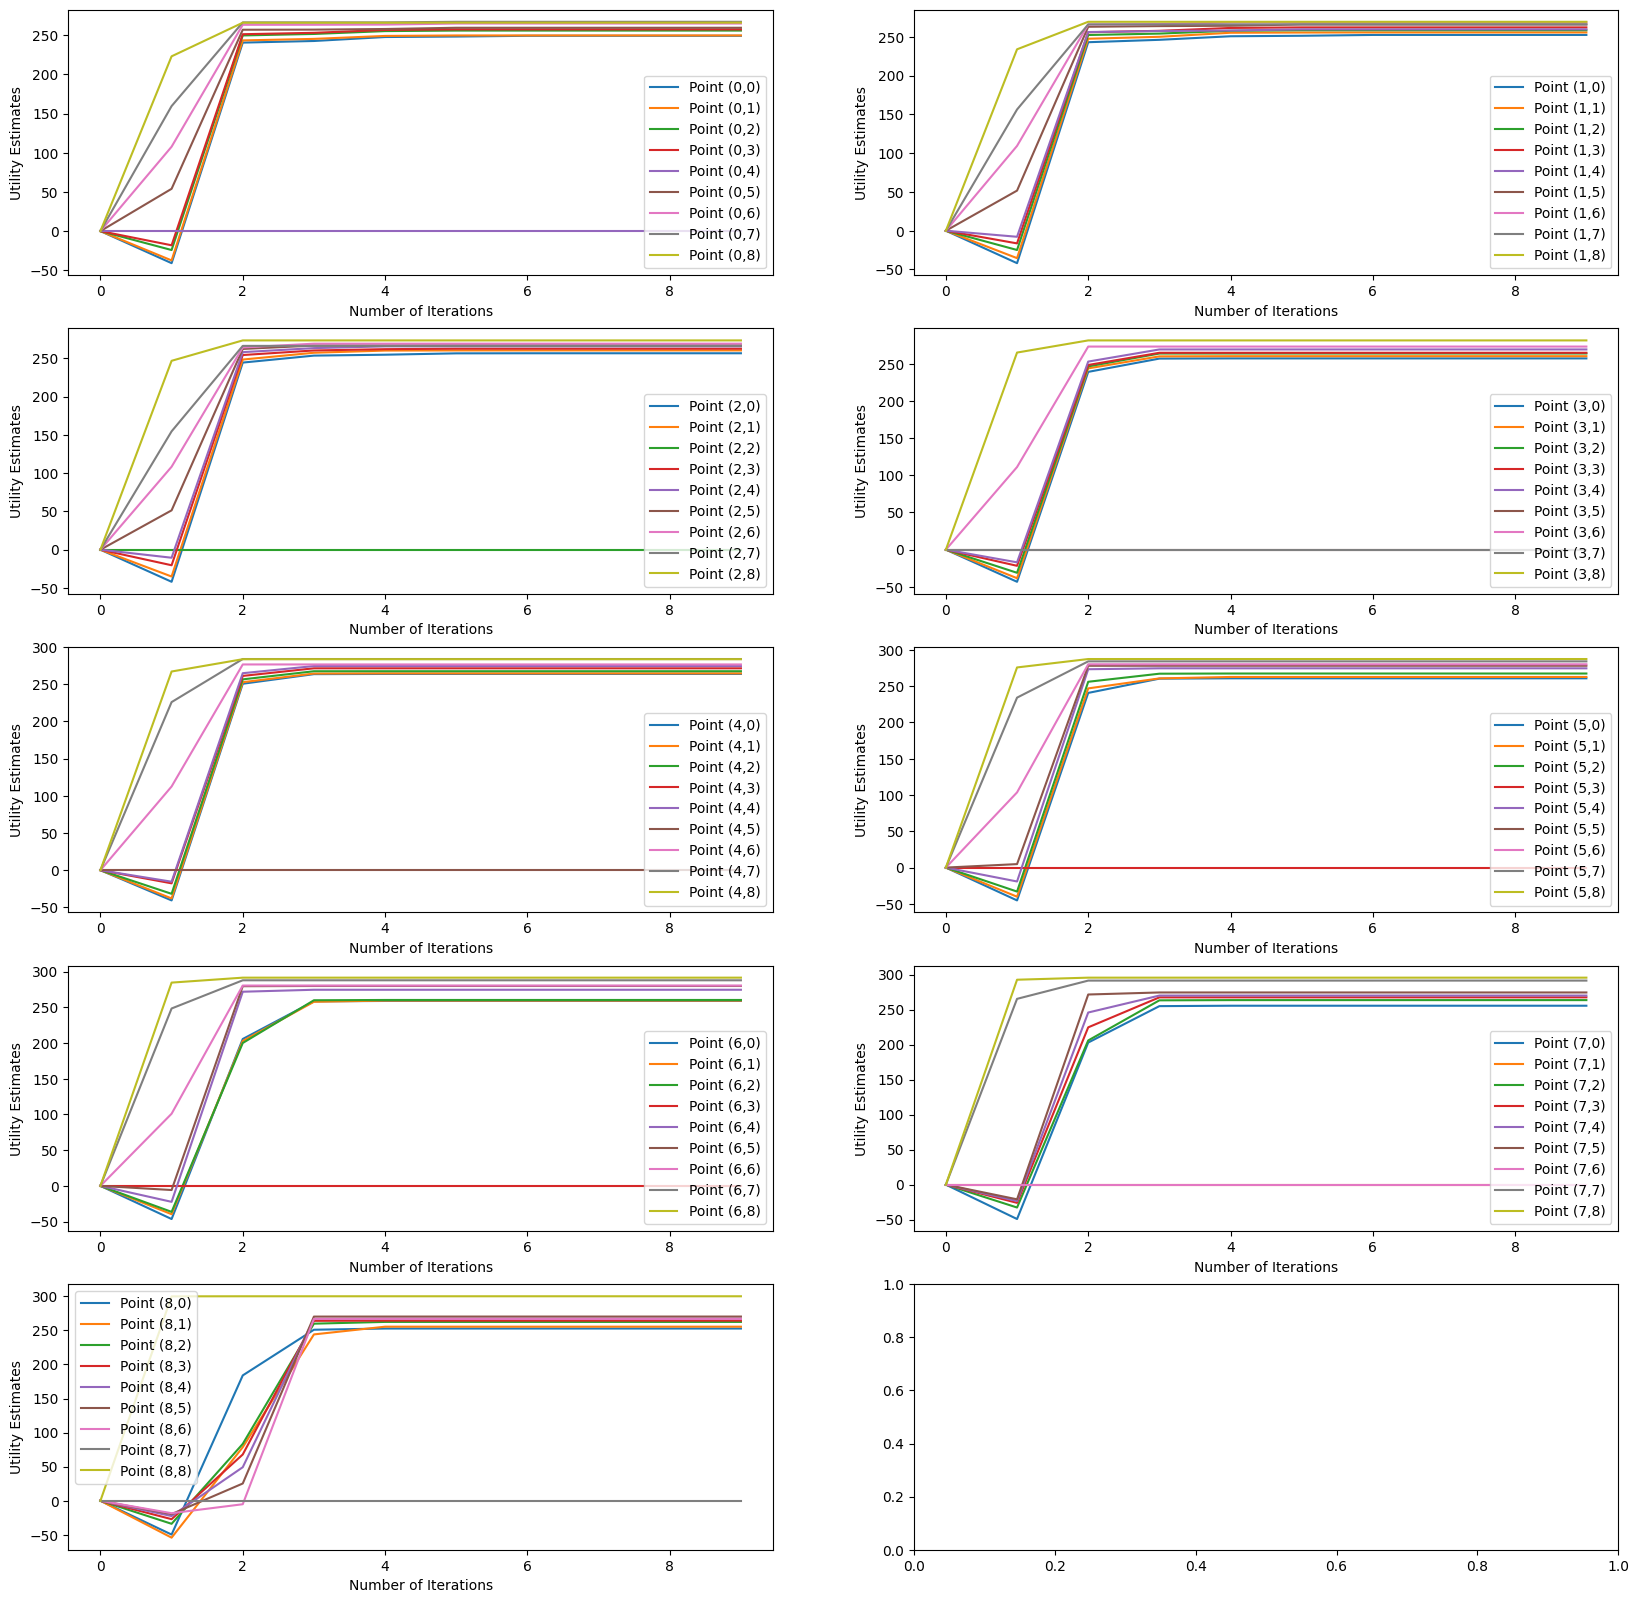

In [260]:
figure, axis = plt.subplots(5, 2)
figure.set_figheight(20)
figure.set_figwidth(20)

for r in range(ROWS):
    for c in range(COLS):
        axis[r // 2, r % 2].plot(iteration_values_np, np.array(utility_estimates[r][c]), label="Point (" + str(r) + "," + str(c) + ")")
        axis[r // 2, r % 2].legend()
        axis[r // 2, r % 2].set_xlabel("Number of Iterations")
        axis[r // 2, r % 2].set_ylabel("Utility Estimates")

plt.show()